# Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define Transform: convert to tensor + normalize

In [2]:
normalize = transforms.Normalize((0.1307,), (0.3081,))
transform = transforms.Compose([transforms.ToTensor(), normalize])

# Loading training and test datasets

In [3]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [4]:
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Number of samples

In [5]:
print(f"Number of training samples: {len(mnist_trainset)}")

Number of training samples: 60000


In [6]:
print(f"Number of test samples: {len(mnist_testset)}")

Number of test samples: 10000


# Image size and shape

In [7]:
image, label = mnist_trainset[0]
print(f"Image tensor shape{image.shape}")
print(f"Label: {label}")

Image tensor shapetorch.Size([1, 28, 28])
Label: 5


# Display the first 5 images with labels

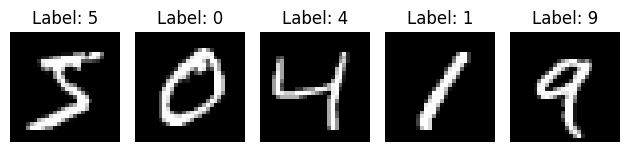

In [8]:
for i in range(5):
    image, label = mnist_trainset[i]
    img = image.squeeze() * 0.1307 + 0.3081 # unnormalize for display
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Loading the datasets

In [9]:
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)

In [10]:
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=1000, shuffle=False)

## Displaying the data distribution of Classes

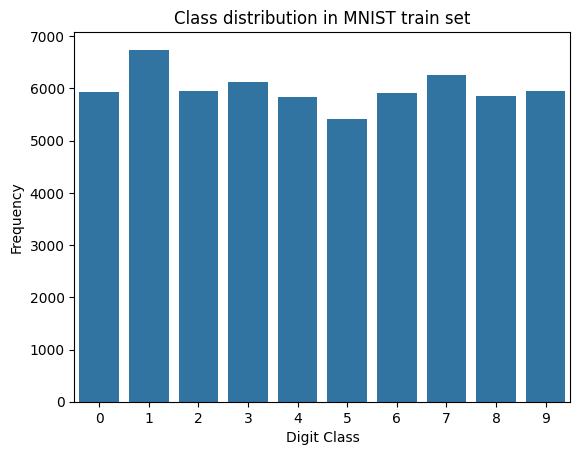

In [11]:
labels = [label for _, label in mnist_trainset]
sns.countplot(x=labels)
plt.title("Class distribution in MNIST train set")
plt.xlabel("Digit Class")
plt.ylabel("Frequency")
plt.show()

## Declaring Classes

In [12]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# Building CNN Model; defining layers and flow of data

In [13]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)

        self.fc1 = nn.Linear(32*7*7, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.pool(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.pool(out)

        out = out.view(-1, 32*7*7)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [14]:
model = CNNModel()

# Loss and Optimizers

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Model while also displaying loss at each epoch

In [16]:
epochs = 10

In [17]:
# Inputs are images and output_orig are labels
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, output_orig in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, output_orig)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch: {epoch}, Loss: {total_loss}")

Epoch: 0, Loss: 133.23895200435072
Epoch: 1, Loss: 40.21521870570723
Epoch: 2, Loss: 26.438351876975503
Epoch: 3, Loss: 19.09470075788704
Epoch: 4, Loss: 15.206715175520003
Epoch: 5, Loss: 10.384496419626885
Epoch: 6, Loss: 9.485945843023728
Epoch: 7, Loss: 7.783272197617407
Epoch: 8, Loss: 6.890628679856718
Epoch: 9, Loss: 7.410082822004142


# Evaluation through Classification Report

In [18]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.99      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



# Confusion Matrix

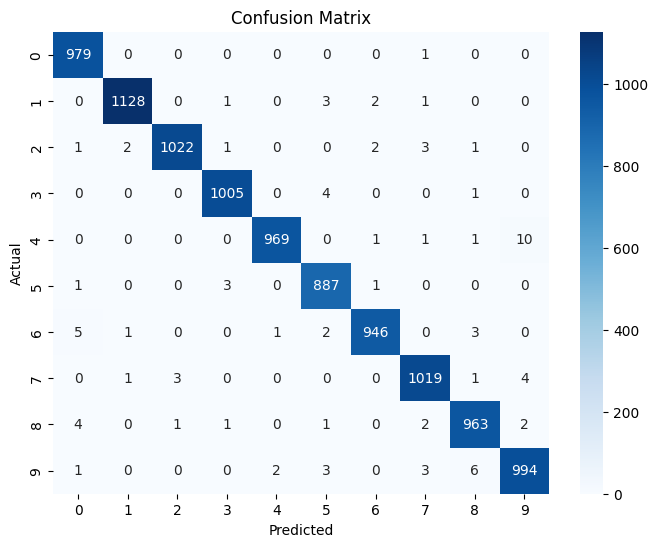

In [19]:
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [20]:
no_of_images_to_show = 5

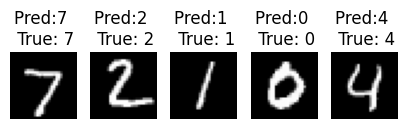

In [21]:
with torch.no_grad():
    for images, labels in test_loader:
        output = model(images)
        _, prediction = torch.max(output, 1)
        plt.figure(figsize=(5,1))
        for i in range(no_of_images_to_show):
            img = images[i]
            plt.subplot(1, no_of_images_to_show, i+1)
            plt.imshow(img.squeeze(), cmap='gray')
            plt.title("Pred:{} \n True: {}".format(prediction[i], labels[i]))
            plt.axis("off")
        plt.show()
        break

### Save the model

In [24]:
torch.save(model.state_dict(), 'cnn_model.pth')

### Load the model

In [26]:
loaded_model = CNNModel()
loaded_model.load_state_dict(torch.load('cnn_model.pth'))

<All keys matched successfully>

### Set the model to evaluation mode

In [27]:
loaded_model.eval()

CNNModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)